### **Helper Functions**

In [36]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
from scipy.stats import kruskal

# Compare two anomaly detection algorithms: isolation forest and local outlier factor. 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Metrics to compare performance of anomaly detection algorithms
from sklearn.metrics import silhouette_score

In [42]:
def predict_anomalies(data): 
    data['min_amount'] = data['min_amount'].astype('float')
    data['max_amount'] = data['max_amount'].astype('float')
    data['total_amount'] = data['total_amount'].astype('float')
    filtered_data = data[['out_degree', 'in_degree', 'tot_transactions', 'total_amount', 'max_amount', 'min_amount']]

    # Isolation Forest 
    isolation_forest = IsolationForest(contamination = 0.01, random_state = 42) # Specify that 1% of data are outliers. 
    data['anomaly_if'] = isolation_forest.fit_predict(filtered_data)

    # Local outlier factor 
    lof = LocalOutlierFactor(contamination = 0.01)
    data['anomaly_lof'] = lof.fit_predict(filtered_data)

    # Calculate silhouette scores
    if_score = silhouette_score(filtered_data, data['anomaly_if'])
    lof_score = silhouette_score(filtered_data, data['anomaly_lof'])

    # Select the algorithm with the highest silhouette score
    scores = {'if': if_score, 'lof': lof_score}
    best_algo = max(scores, key=scores.get)

    # Apply the best algorithm for the final classification
    data['anomaly'] = data[f'anomaly_{best_algo}']
    data['type_of_address'] = data['anomaly'].apply(lambda x: 'likely anomaly' if x == -1 else 'normal')

    algo_names = {
        'if': 'Isolation forest',
        'svm': 'One-class SVM', 
        'lof': 'Local outlier factor'
    }

    print(f"The model used for anomaly detection is: {algo_names[best_algo]}") 
    data = data[['sender', 'out_degree', 'in_degree', 'tot_transactions', 'total_amount', 'max_amount', 'min_amount', 'type_of_address']]
    return data

In [40]:
def display_boxplot(data): 
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))
    
    axs = axs.flatten()
    
    sns.boxplot(x='type_of_address', y='tot_transactions', data=data, ax=axs[0])
    axs[0].set_title('Total Transactions by Address Type')
    
    sns.boxplot(x='type_of_address', y='in_degree', data=data, ax=axs[1])
    axs[1].set_title('In-Degree by Address Type')
    
    sns.boxplot(x='type_of_address', y='out_degree', data=data, ax=axs[2])
    axs[2].set_title('Out-Degree by Address Type')
    
    sns.boxplot(x='type_of_address', y='max_amount', data=data, ax=axs[3])
    axs[3].set_title('Max Amount by Address Type')
    
    sns.boxplot(x='type_of_address', y='min_amount', data=data, ax=axs[4])
    axs[4].set_title('Min Amount by Address Type')

    sns.boxplot(x='type_of_address', y='total_amount', data=data, ax=axs[5])
    axs[4].set_title('Total Amount by Address Type')

    plt.tight_layout()
    plt.show()

In [38]:
def kruskal_wallis_test(data): 
    columns = ['out_degree', 'in_degree', 'tot_transactions', 'total_amount', 'max_amount']
    for column in columns: 
        normal_group = data[data['type_of_address'] == 'normal'][column]
        anomaly_group = data[data['type_of_address'] == 'likely anomaly'][column]
        
        # Perform the Kruskal-Wallis test
        stat, p_value = kruskal(normal_group, anomaly_group)
        
        # Display the results
        print(f"Kruskal-Wallis Test for {column}:")
        
        if p_value < 0.05:
            print(f"There is a statistically significant difference in the median of {column} between the groups.\n")
        else:
            print(f"There is no statistically significant difference in the median of {column} between the groups.\n")

### **Iotex Anomaly Detection**

In [43]:
# Contains addresses whose total number of transaction is greater than 10000 from 2019 to 2023
iotex_influential_address = pd.read_csv('/Users/kelvinfoo/Desktop/Crypto Research/Bitcoin and Ethereum Basic Statistics/Iotex/Month by month/Most influential nodes.csv')

iotex_anomalies = predict_anomalies(iotex_influential_address)
iotex_anomalies.head()

The model used for anomaly detection is: Local outlier factor


,sender,out_degree,in_degree,tot_transactions,total_amount,max_amount,min_amount,type_of_address
0,io1lwc9nuu3gz3jm65s7u4ylwwyuf34pxq27dfq89,719,885,13200,8.210149e+24,1.048114e+23,0.000000e+00,normal
1,io1p5rs093e2te0hfva6phjksj6eeqtfyh78wmd5f,2738,3310,16272,8.676190e+26,9.999980e+24,1.000000e+16,normal
2,io1he2uzmvedelr3q09s00h8fekj7qxtnzsnnweu2,4162,6723,16084,6.079976e+26,3.000000e+25,1.000000e+16,normal
3,io1z85pftu0rvhu3x4k3acqrulvlu7a7dlamstxt9,23,14,17779,4.210062e+25,1.060000e+23,0.000000e+00,normal
4,io1z59lrha2jvm8pd2adeq2wvnun285qqq44wd9k9,16,8,17016,9.908246e+22,3.500000e+21,1.000000e+16,normal


In [53]:
iotex_anomalies.to_csv('iotex_anomalies.csv')

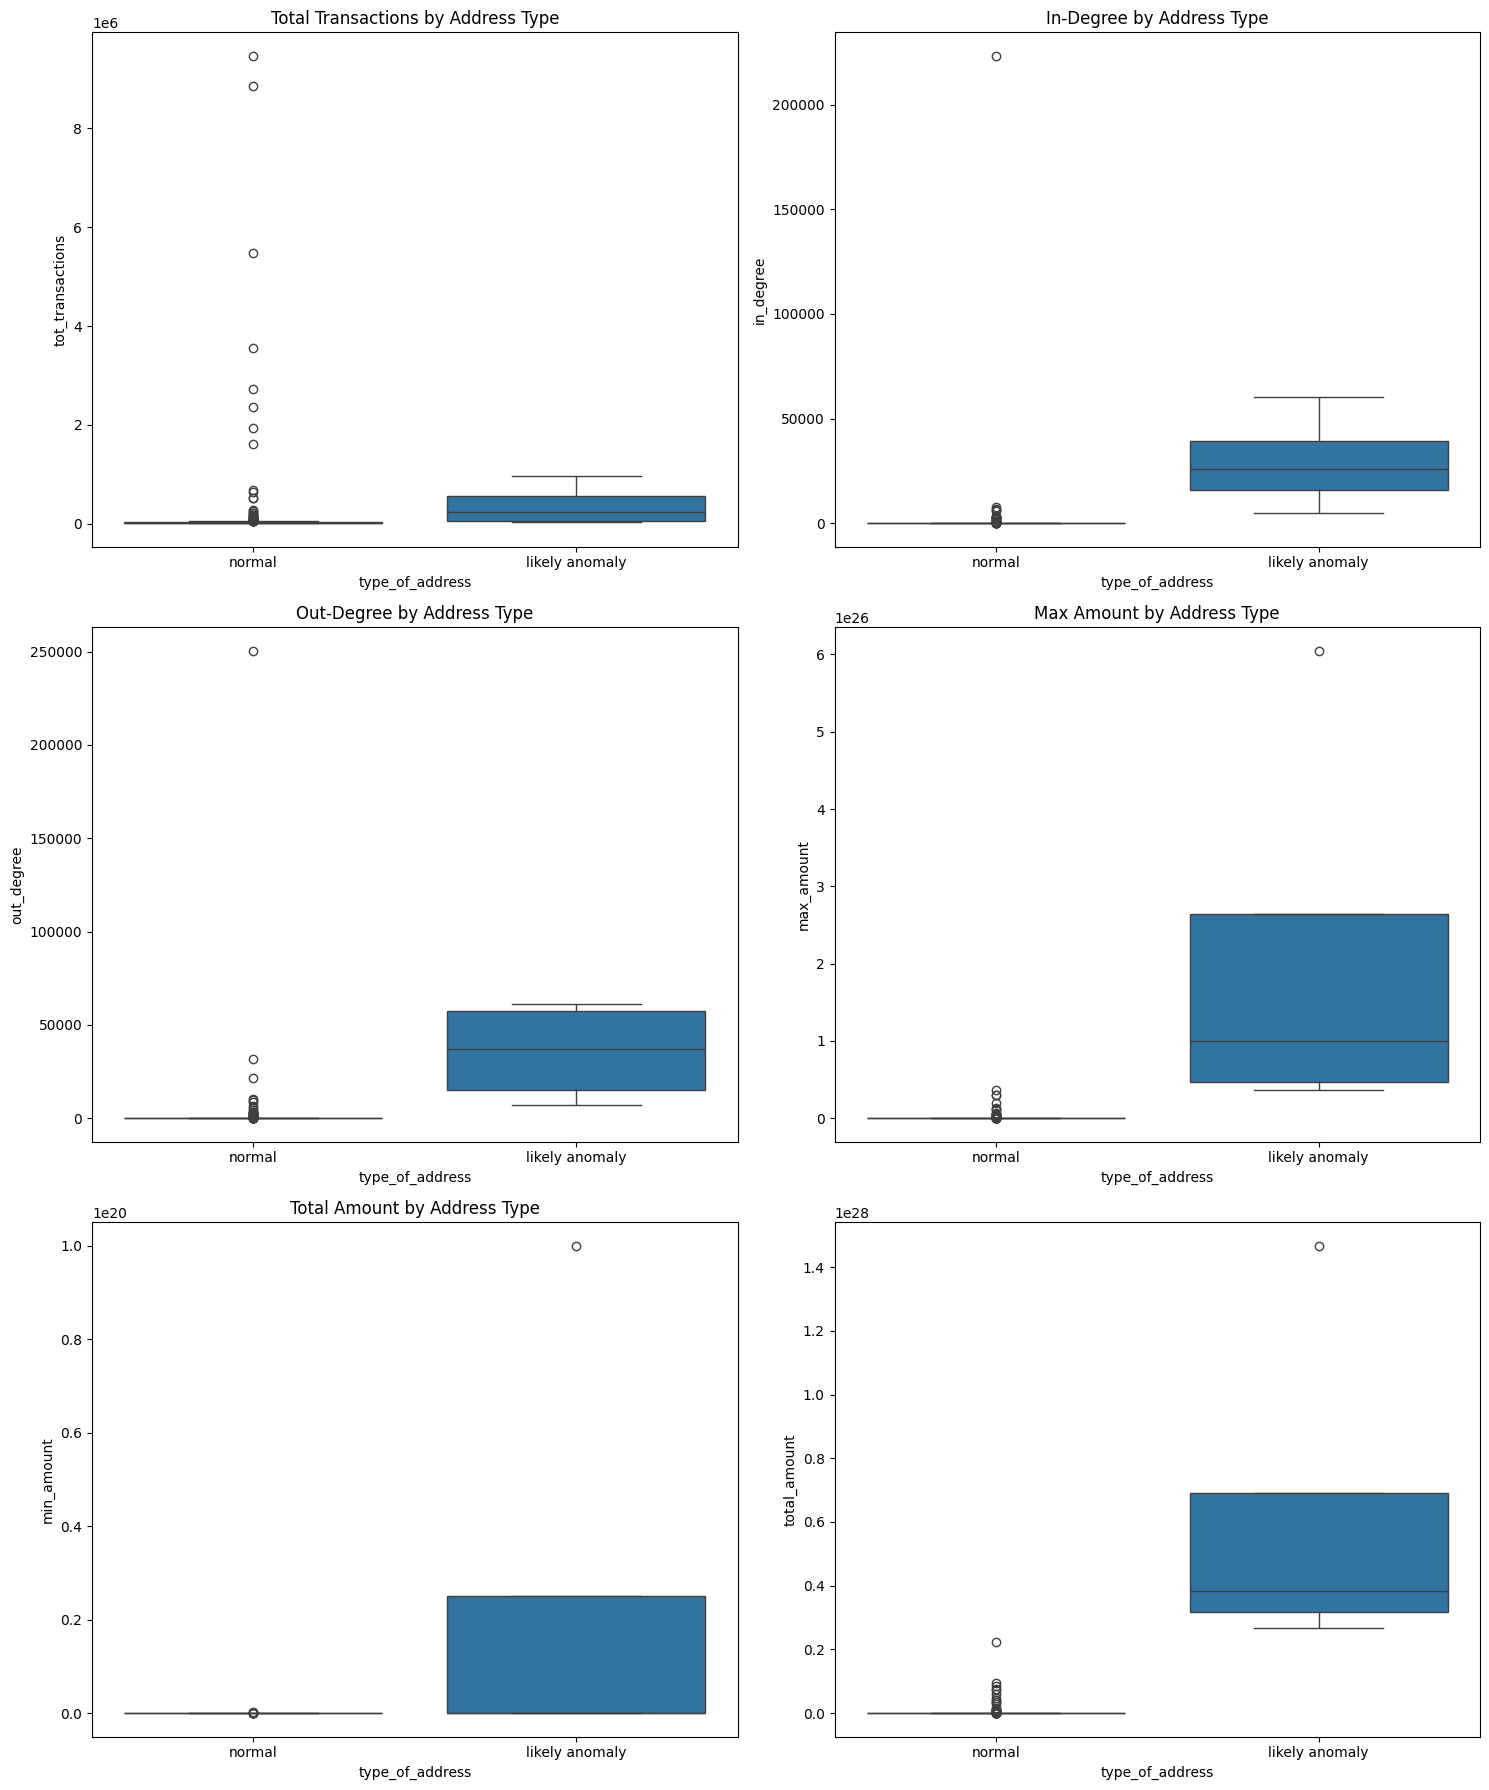

In [44]:
display_boxplot(iotex_anomalies)

In [45]:
kruskal_wallis_test(iotex_anomalies)

Kruskal-Wallis Test for out_degree:
There is a statistically significant difference in the median of out_degree between the groups.

Kruskal-Wallis Test for in_degree:
There is a statistically significant difference in the median of in_degree between the groups.

Kruskal-Wallis Test for tot_transactions:
There is a statistically significant difference in the median of tot_transactions between the groups.

Kruskal-Wallis Test for total_amount:
There is a statistically significant difference in the median of total_amount between the groups.

Kruskal-Wallis Test for max_amount:
There is a statistically significant difference in the median of max_amount between the groups.



### **Tezos Anomaly Detection**

In [46]:
tezos_influential_address = pd.read_csv('/Users/kelvinfoo/Desktop/Crypto Research/Bitcoin and Ethereum Basic Statistics/Tezos/Month by month/Most influential nodes.csv')
tezos_anomalies = predict_anomalies(tezos_influential_address)
tezos_anomalies.head()

The model used for anomaly detection is: Isolation forest


,sender,out_degree,in_degree,tot_transactions,total_amount,max_amount,min_amount,type_of_address
0,KT1UMAE2PBskeQayP5f2ZbGiVYF7h8bZ2gyp,1570,1892,53736,1.953346e+12,1.758010e+10,0.0,normal
1,tz1VeaJWkdr2m5YaKFgeAafenhHhDcMxWfHC,12776,5518,35392,1.210890e+14,4.167230e+11,10000.0,normal
2,tz1iVUtqsSDxEYL9SAvbMdwm4FzSr3McWH6m,255,3,31648,5.783298e+10,1.000000e+09,2221.0,normal
3,KT1PxkrCckgh5fA5v2cZEE2bX5q2RV1rv8dj,3,2799,111350,0.000000e+00,0.000000e+00,0.0,normal
4,tz1bDXD6nNSrebqmAnnKKwnX1QdePSMCj4MX,33384,35207,103631,4.887336e+14,8.000000e+12,50000.0,likely anomaly


In [54]:
tezos_anomalies.to_csv('tezos_anomalies.csv')

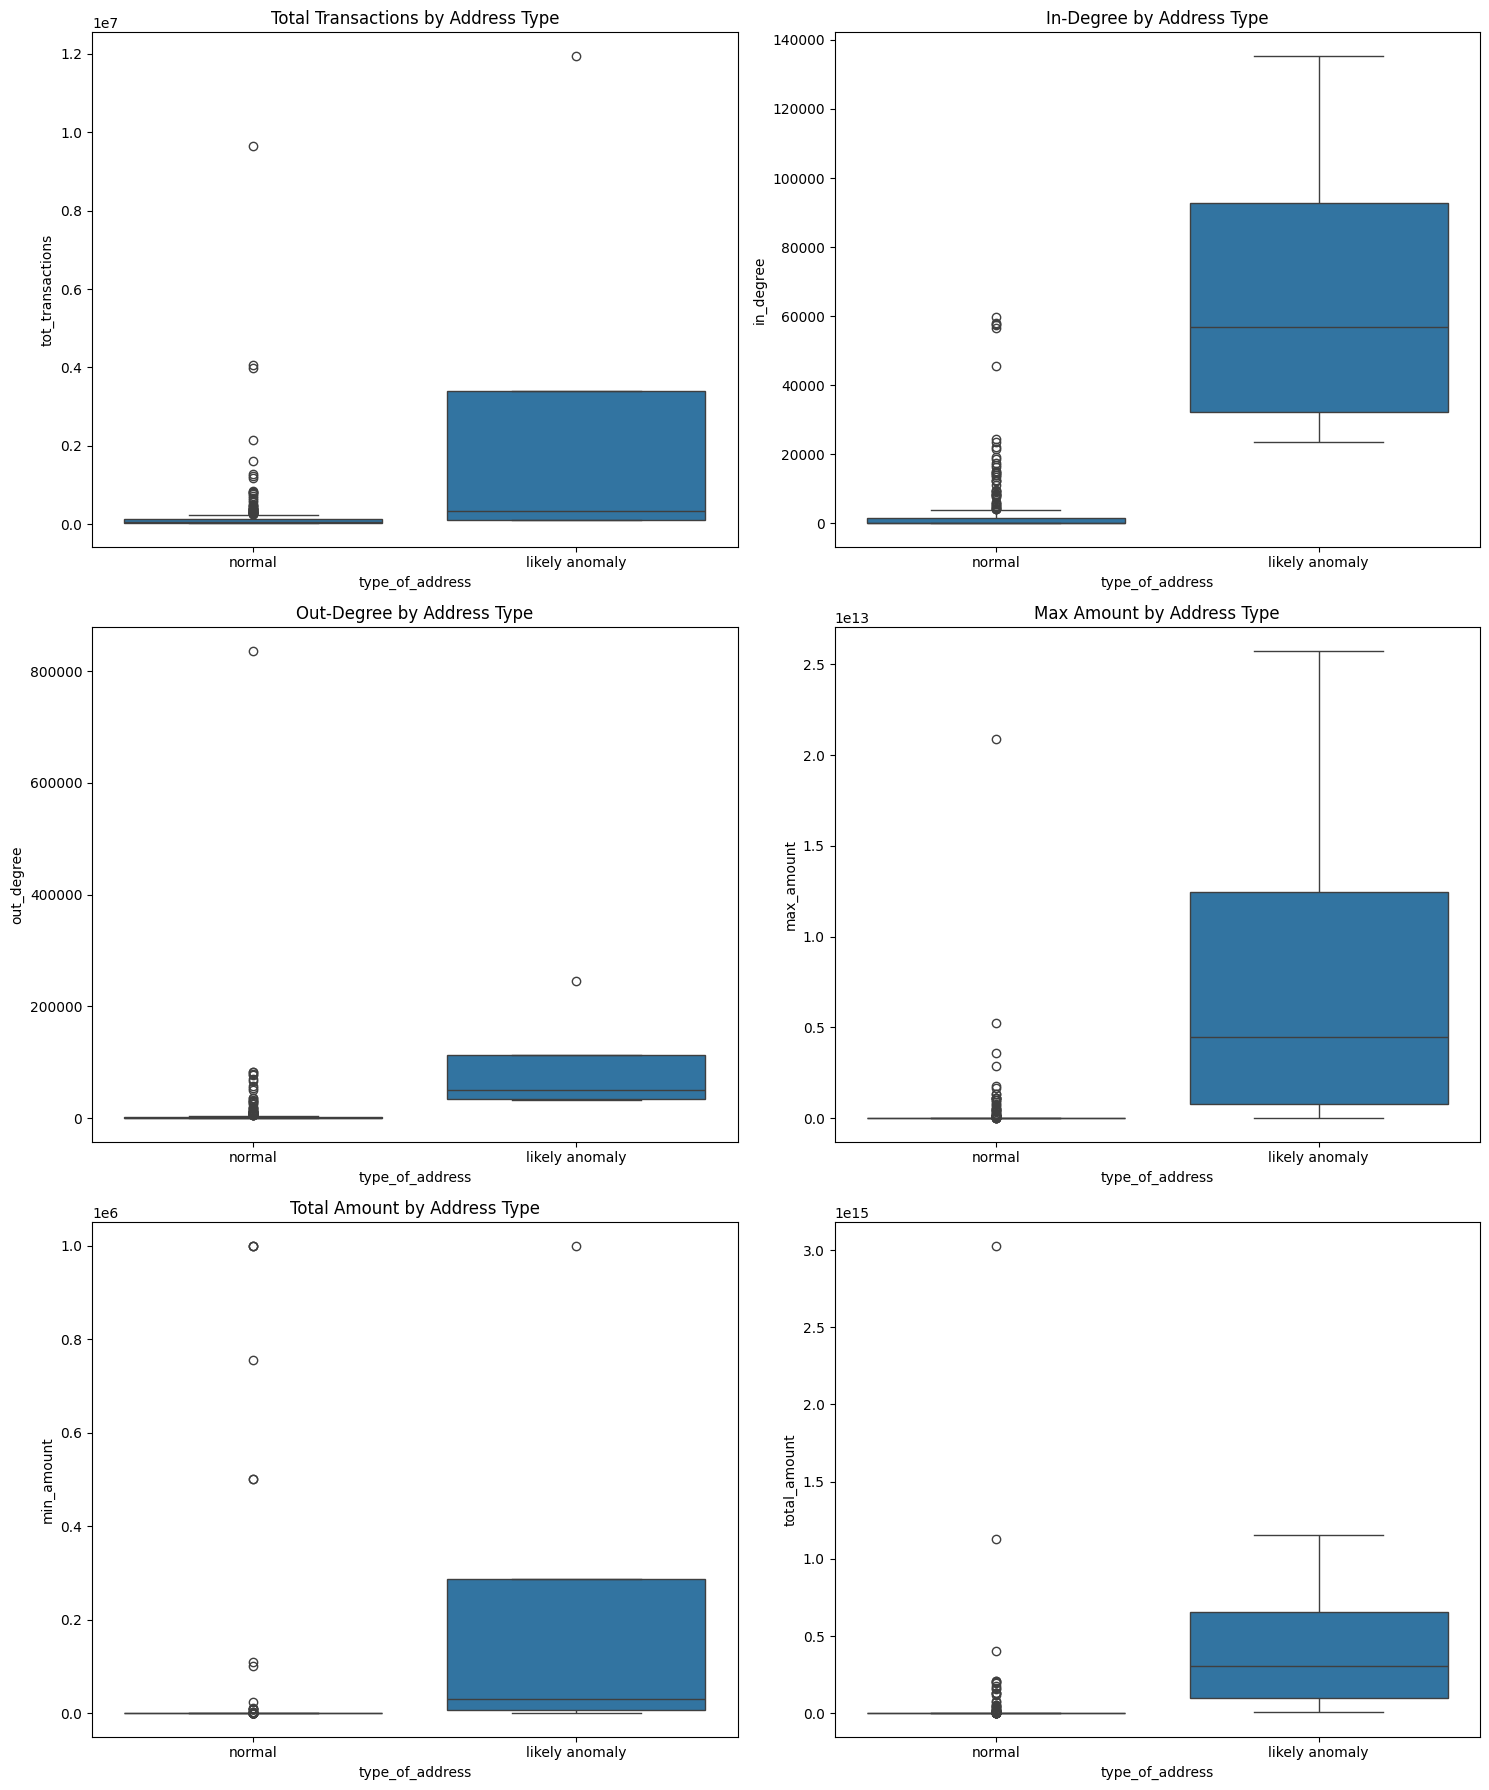

In [47]:
display_boxplot(tezos_anomalies)

In [48]:
kruskal_wallis_test(tezos_anomalies)

Kruskal-Wallis Test for out_degree:
There is a statistically significant difference in the median of out_degree between the groups.

Kruskal-Wallis Test for in_degree:
There is a statistically significant difference in the median of in_degree between the groups.

Kruskal-Wallis Test for tot_transactions:
There is a statistically significant difference in the median of tot_transactions between the groups.

Kruskal-Wallis Test for total_amount:
There is a statistically significant difference in the median of total_amount between the groups.

Kruskal-Wallis Test for max_amount:
There is a statistically significant difference in the median of max_amount between the groups.



### **Ethereum Anomaly Detection**

In [49]:
ethereum_influential_address = pd.read_csv('/Users/kelvinfoo/Desktop/Crypto Research/Bitcoin and Ethereum Basic Statistics/Ethereum/Month by month/Most influential nodes.csv')
ethereum_anomalies = predict_anomalies(ethereum_influential_address)
ethereum_anomalies.head()

The model used for anomaly detection is: Isolation forest


,sender,out_degree,in_degree,tot_transactions,total_amount,max_amount,min_amount,type_of_address
0,0xde48a49359d9f0c8609221f77f382e1472ddbab7,14421,15,166436,8.600000e+18,3.000000e+18,0.000000e+00,normal
1,0xfdf1946a9b40245224488f1a36f4a9ed4844a523,6,10,317331,5.398018e+18,5.394418e+18,0.000000e+00,normal
2,0xc5341278a92e2bd8203ab931c6780c15d367713f,21478,85996,908292,6.911230e+23,9.430000e+21,0.000000e+00,normal
3,0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40,38258,33,2390462,8.268036e+19,3.558224e+16,0.000000e+00,normal
4,0x6596da8b65995d5feacff8c2936f0b7a2051b0d0,410715,1,685952,4.107275e+21,1.208696e+18,1.000000e+11,normal


In [55]:
ethereum_anomalies.to_csv('ethereum_anomalies.csv')

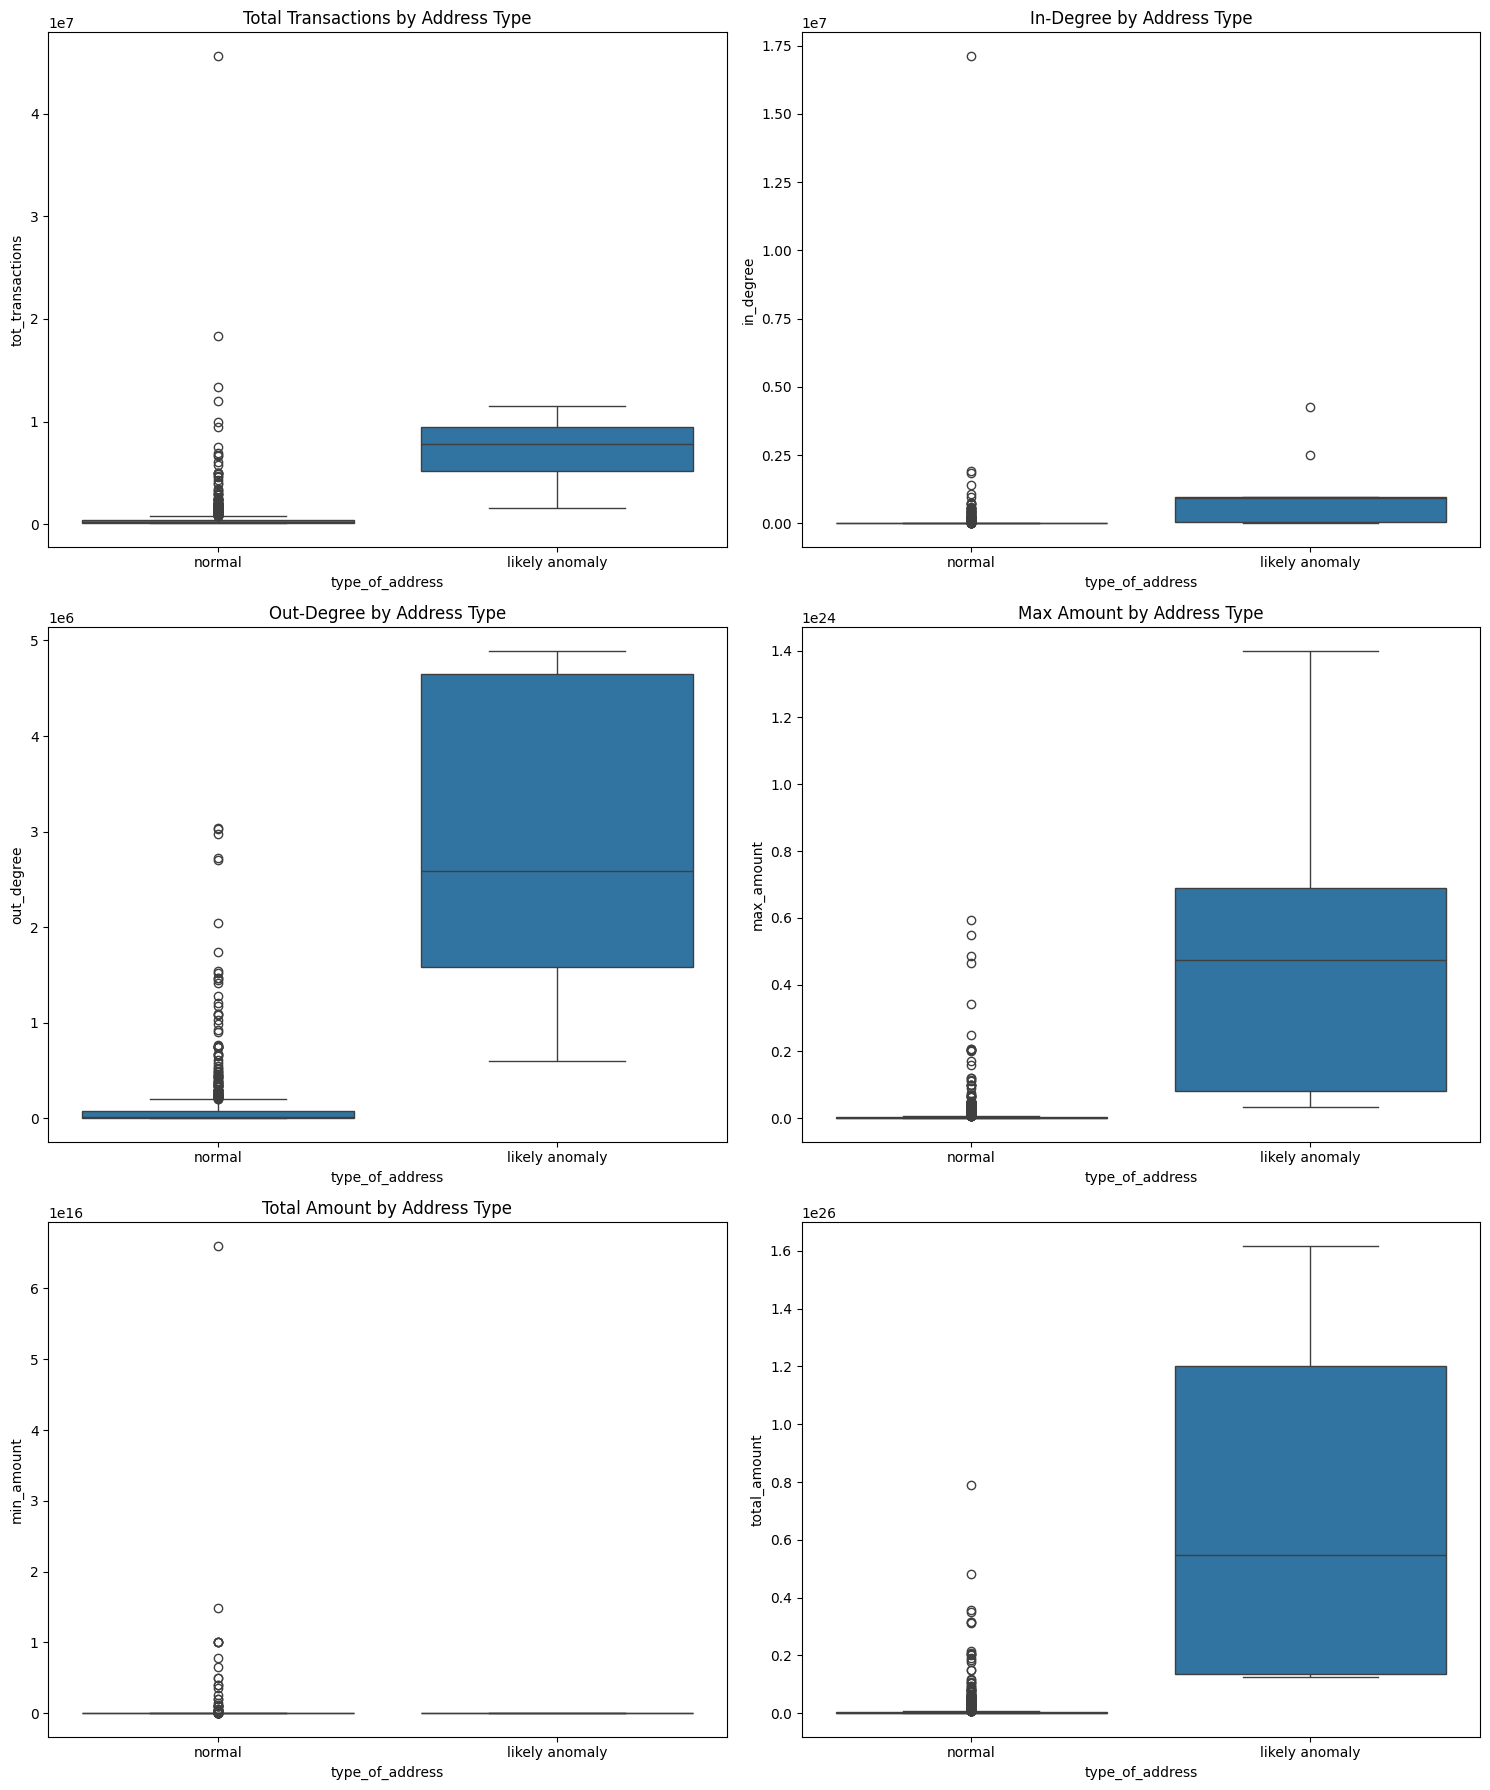

In [50]:
display_boxplot(ethereum_anomalies)

In [51]:
kruskal_wallis_test(ethereum_anomalies)

Kruskal-Wallis Test for out_degree:
There is a statistically significant difference in the median of out_degree between the groups.

Kruskal-Wallis Test for in_degree:
There is a statistically significant difference in the median of in_degree between the groups.

Kruskal-Wallis Test for tot_transactions:
There is a statistically significant difference in the median of tot_transactions between the groups.

Kruskal-Wallis Test for total_amount:
There is a statistically significant difference in the median of total_amount between the groups.

Kruskal-Wallis Test for max_amount:
There is a statistically significant difference in the median of max_amount between the groups.

